Three 3D Elasticity-beam problem
===

Haneesh_Kesari@brown.edu



* _**Example 3D elasticity simulation**_
    * Creating and visualizing the mesh
    * Set up and solution of a 3D elasticity problem 
    * Saving the solution as an xml file
    * Reading an xml file and plotting displacent along a space curve
    * Contour plot of a displacement component, e.g., $u_3$, on a cross-section of the beam
    * Computation of sress and forces from the continuum mechanics forms
    * Creating the defomed mesh


In [1]:
import numpy as np
from SDomains import *
from fenics import *
from dolfin import *

In [2]:
# Geometry and Material Parameters
from MatGeoProp import W, Length
from MatGeoProp import nx, ny, nz, tol
from MatGeoProp import rho, g

In [3]:
# Create mesh and define function space
mesh = BoxMesh(Point(0, 0, 0), Point(Length, W, W), nx, ny, nz)

# V = VectorFunctionSpace(mesh, 'CG', 1,3)
# Vt = TensorFunctionSpace(mesh, 'CG', 1)

V = VectorFunctionSpace(mesh, 'CG', 2,3)
Vt = TensorFunctionSpace(mesh, 'CG', 2)


# V = VectorFunctionSpace(mesh, 'P', 1)
# Vt = TensorFunctionSpace(mesh, 'P', 1)

# V = VectorFunctionSpace(mesh, 'P', 2)
# Vt = TensorFunctionSpace(mesh, 'P', 2)

In [4]:
mesh # visualize the mesh

#### Define Boundary Conditions ####

In [5]:
from ufl import nabla_div

In [6]:
from MatGeoProp import tol
def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol

bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)

<h4>Define stress and strain<h4>

In [7]:
#Define function spaces
u = TrialFunction(V)
v = TestFunction(V)

# Define Variational Problem
from MatGeoProp import lambda_, mu
d = u.geometric_dimension()  # space dimension
def epsilon(u):
    return 0.5 * (nabla_grad(u) + nabla_grad(u).T)


def sigma(u):
    return lambda_ * nabla_div(u) * Identity(d) + 2 * mu * epsilon(u)# Compute solution

<h4>Define loading<h4>

In [8]:
f = Constant((0, 0, rho * g))
T = Constant((0, 0, 0))

a = inner(sigma(u), epsilon(v)) * dx
L = dot(f, v) * dx + dot(T, v) * ds

<h4>Solve<h4>

In [2]:
# Compute solution
u = Function(V)
problem = LinearVariationalProblem(a, L, u, bc)
solver = LinearVariationalSolver(problem)
solver.parameters["linear_solver"] = "cg"
solver.solve()  # solve(a==L,u,bc)

NameError: name 'Function' is not defined

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

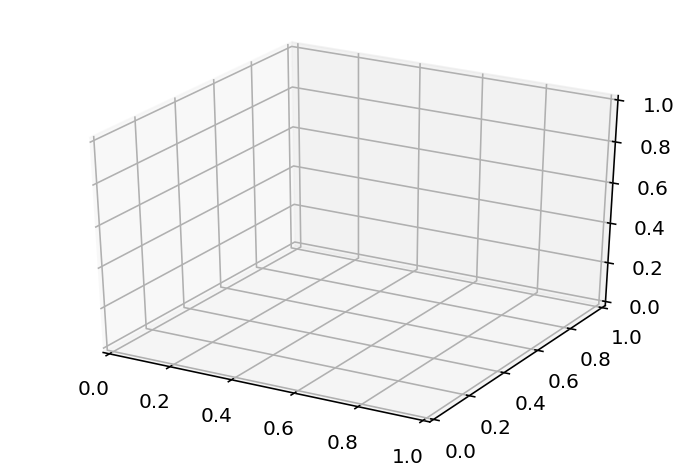

In [10]:
%matplotlib inline
plot(mesh, interactive=True)
#plot(u, interactive=True)

<h4>Save<h4>

In [11]:

File('Displacement_Field20.xml') << u

<h4>Extract displacements from saved file<h4>

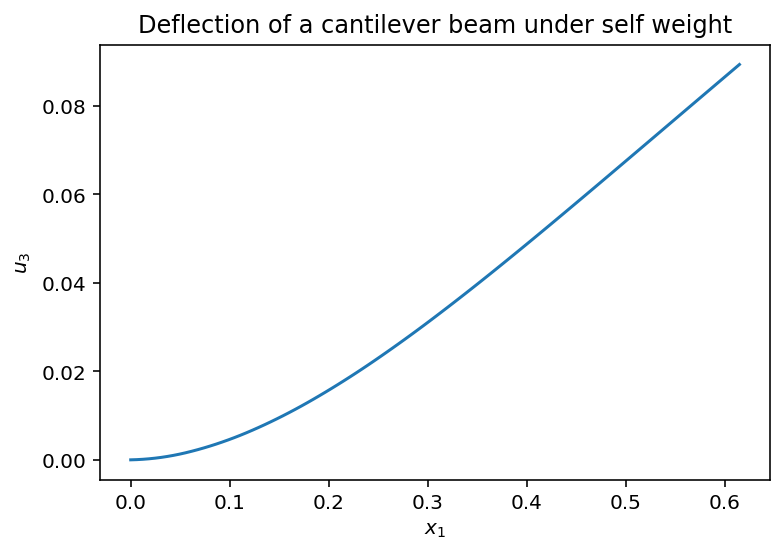

<Figure size 432x288 with 0 Axes>

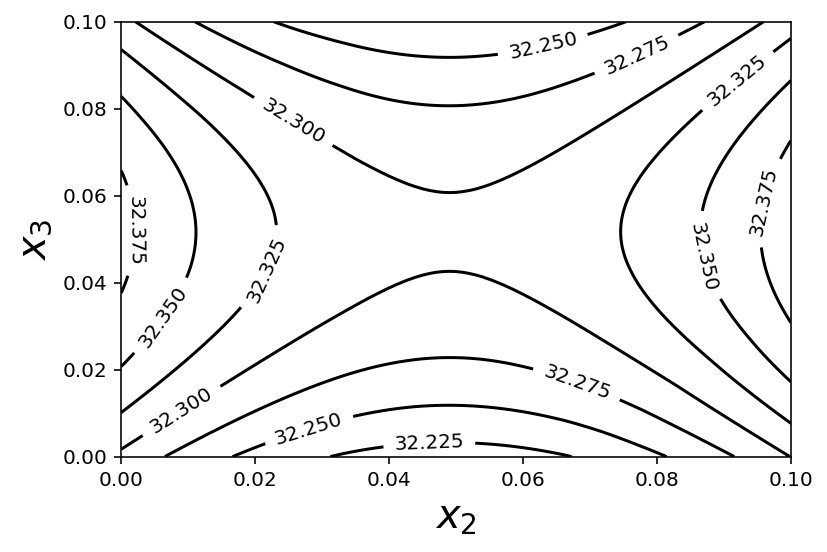

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt


u= Function(V, 'Displacement_Field20.xml')





Npoints=101
midline_x = np.linspace(0+tol, Length-tol, Npoints)
midline_points=[(x_, W/2, W/2) for x_ in  midline_x]
midline_u = np.array([u(point) for point in midline_points])


plt.plot(midline_x, midline_u[:,2])
plt.xlabel('$x_1$')
plt.ylabel('$u_3$')
plt.title('Deflection of a cantilever beam under self weight')
plt.show()
plt.savefig('3DBeam_s11.pdf')


x2 = np.linspace(0+tol, W-tol, Npoints)
x3= np.linspace(0+tol, W-tol, Npoints, Npoints)
X2, X3 = np.meshgrid(x2, x3)
#
U2=np.empty([Npoints,Npoints])
#
for i in range(0,Npoints,1):
    for j in range(0,Npoints,1):
        #print(i,j)
        uv=u((Length/2, x2[i], x3[j]))
        U2[i,j]=uv[2]

plt.figure()
CS=plt.contour(X2,X3, 1000*U2,colors='k')
plt.clabel(CS, fontsize=10)
plt.xlabel( "$x_2$",fontsize=20)
plt.ylabel( "$x_3$",fontsize=20)
plt.show()

<h4>Computation of stress<h4>

In [13]:
# # Compute stress
st = sigma(u)
st = project(st, Vt)
s11, s12, s13, s21, s22, s23, s31, s32, s33 = st.split(deepcopy=True)
print("Calculation of stress components complete")


ex = Constant((-1.0, 0.0, 0.0))
ey = Constant((0.0, 1.0, 0.0))
ez = Constant((0.0, 0.0, 1.0))

Calculation of stress components complete


In [0]:
from dolfin.cpp.mesh import Face

In [14]:
markers = FaceFunctionSizet(mesh, 1)
TopBoundary().mark(markers, 1)
LeftBoundary().mark(markers, 2)
ds = ds[markers]

fx = dot(dot(st, ex), ex) * ds(2, domain=mesh)
fy = dot(dot(st, ex), ey) * ds(2, domain=mesh)
fz = dot(dot(st, ex), ez) * ds(2, domain=mesh)

fx = assemble(fx)
fy = assemble(fy)
fz = assemble(fz)

NameError: name 'FaceFunctionSizet' is not defined

In [0]:
fz

#### Creating the deformed mesh ####

In [15]:
# Lagrangian coordinates
X1=mesh.coordinates()[:,0].copy()
X2=mesh.coordinates()[:,1].copy()
X3=mesh.coordinates()[:,2].copy()
x1=mesh.coordinates()[:,0].copy()
x2=mesh.coordinates()[:,1].copy()
x3=mesh.coordinates()[:,2].copy()

In [16]:

# Eulerian coordinates
 
class EulerianPoint:
    """ A class represents and manipulates x,y coords. """

    def __init__(self, X1=0.0,X2=0.0,X3=0.0,u1=0.0,u2=0.0,u3=0.0,alpha=1.0):
        """ Create a new point at the origin """
        self.x1=X1+alpha*u1
        self.x2=X2+alpha*u2
        self.x3=X3+alpha*u3
        

        

for i in range(len(X1)):
    [u1, u2, u3]=u((X1[i],X2[i],X3[i]))
    x=EulerianPoint(X1[i],X2[i],X3[i],u1,u2,u3,2)
    x1[i]=x.x1
    x2[i]=x.x2
    x3[i]=x.x3
    
    

In [17]:
DefMesh = BoxMesh(Point(0, 0, 0), Point(Length, W, W), nx, ny, nz)
xyz_cords=np.array([x1, x2, x3]).transpose()
DefMesh.coordinates()[:]=xyz_cords
[DefMesh,mesh]

In [18]:
DefMesh

In [19]:
mesh

In [23]:
nx

10